## Импортируем необходимые библиотеки и функции

In [1]:
import sys
sys.path.append("/home/user/Projects/BOSK/")

from bosk.imports import *
from bosk.utils import *

%load_ext autoreload
%autoreload 2

/home/user/Projects/BOSK/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Определяем модели для тестирования

In [5]:
model_paths = [
    "../models/segformer_1.pth",
    "../models/unet_with_mobilenet_2.pth",
    "../models/newest_deeplab.pth",
]
model_types = ["segformer", "unet_mobile", "deeplab"]
assert (
    model_paths is not None and model_types is not None
), "Enter path for loading model and model's type"

## Функции предобработки изображений

In [3]:
transform = T.Compose([T.Resize((512, 512)), T.ToTensor()])
processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

/home/user/Projects/BOSK/venv/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


## Cоздание папок train, valid и test (не нужно запускать, если уже созданы)

In [ ]:
# source_directory = "./data/roads"  # Путь к исходной директории с файлами
# split_files_into_train_val_test(source_directory)

## Сравниваем предсказания моделей на тестовом датасете

Результат работы модели  ./models/segformer_1.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loss =  tensor(0.0609)
IoU score =  tensor(0.8415)
Dice score =  tensor(0.9762)
Результат работы модели  ./models/unet_with_mobilenet_2.pth
Loss =  tensor(0.0663)
IoU score =  tensor(0.8120)
Dice score =  tensor(0.9756)
Результат работы модели  ./models/newest_deeplab.pth
Loss =  tensor(0.1074)
IoU score =  tensor(0.7612)
Dice score =  tensor(0.9555)


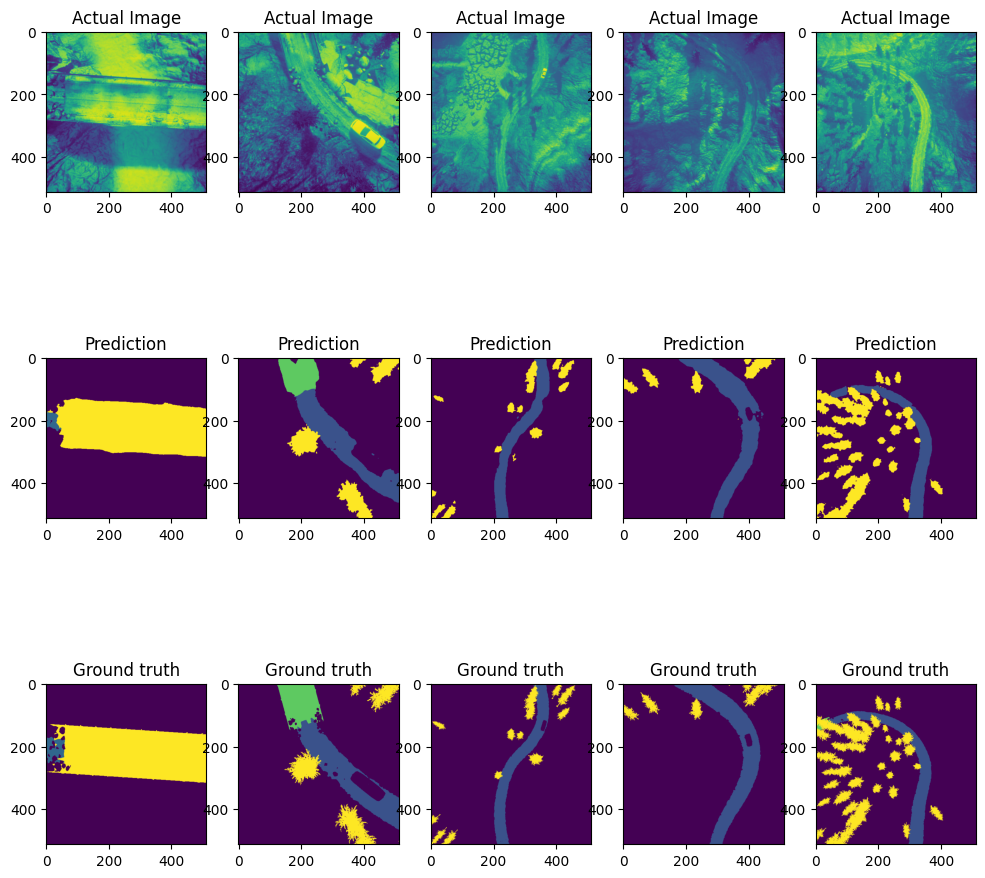

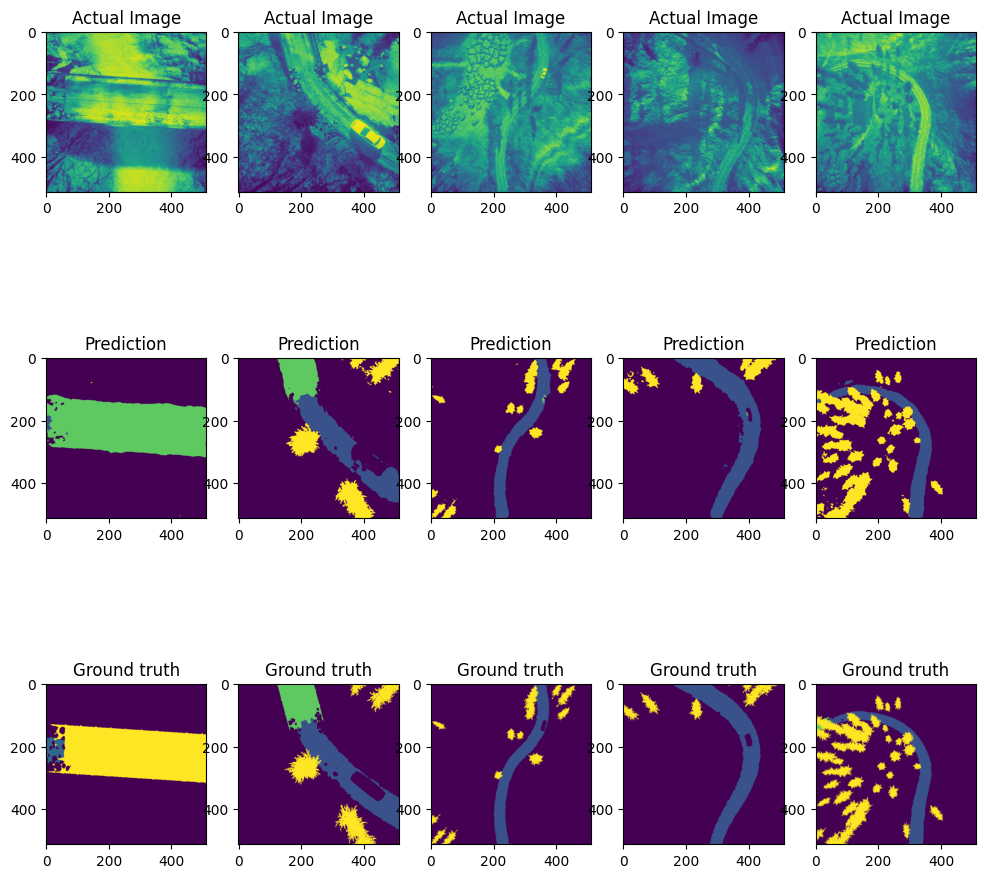

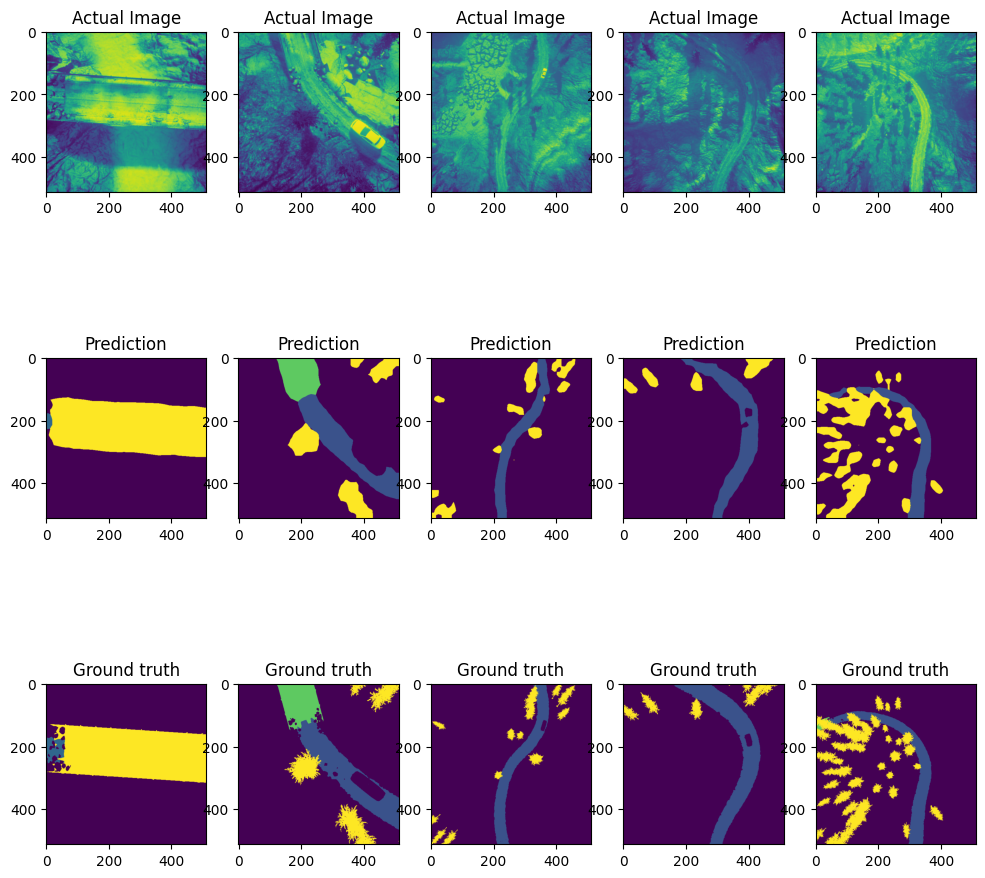

In [ ]:
for model_path, model_type in zip(model_paths, model_types):
    print("Результат работы модели ", model_path)
    model = load_model(model_path, model_type)
    test_dataset = VALID_Dataset(
        root_dir="./data/roads/test",
        model_type=model_type,
        transform=transform,
        processor=processor,
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    testing_model(model, test_loader, model_type, visualization=True)

## Сравниваем предсказания моделей на произвольной картинке 

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


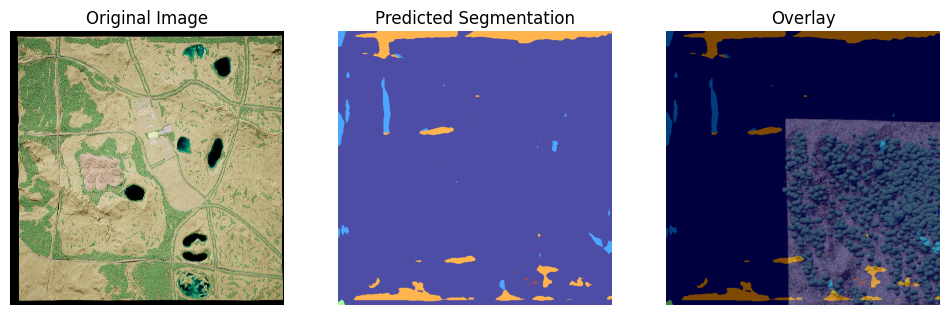

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/user/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 21.7MB/s]


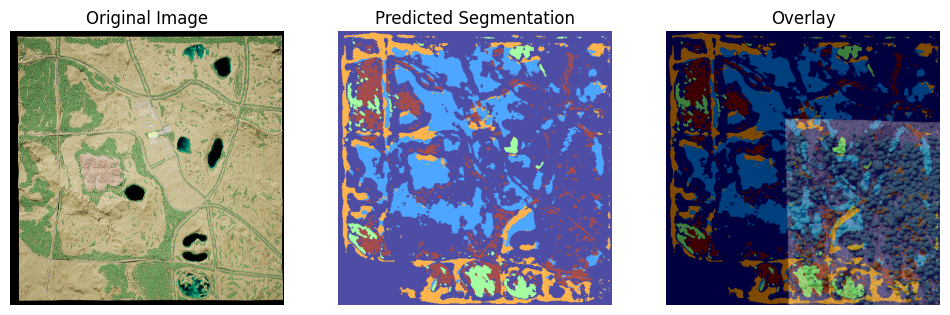

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/user/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 25.9MB/s]


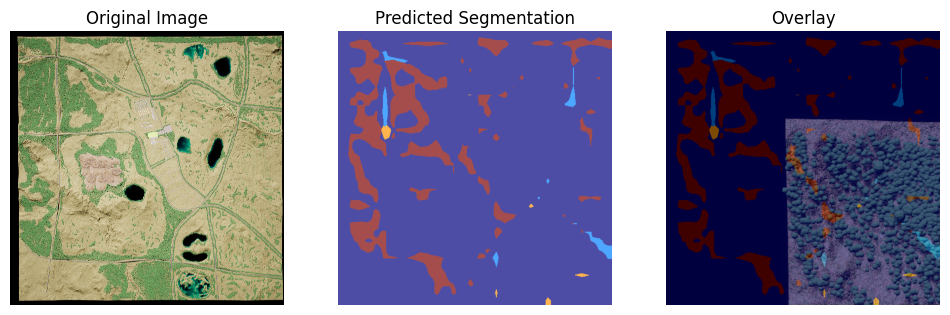

In [7]:
models = []

image_path = "../Some_images/Landscape_Bosk.png"
for model_path, model_type in zip(model_paths, model_types):
    model = load_model(model_path, model_type)
    models.append((model, model_path))
    predict_for_one_image(model, image_path, model_type, transform)

## Смотрим пердсказания на общей карте

In [ ]:
model_path = "./models/segformer_for_large_image.pth"
model = load_model_for_large_image(model_path, num_classes=2, device="cuda")
predict_for_one_image(model, image_path, model_type, transform)

## Сравниваем время работы

In [13]:
import time


def infer_time(net, path="./map.png", dev="cuda"):
    img = Image.open(path).convert("RGB")
    if transform:
        trf = transform
        inp = trf(img).unsqueeze(0).to(dev)
    if processor:
        encoding = processor(img, return_tensors="pt")
        inp = encoding["pixel_values"].to(dev)
    st = time.time()
    out1 = net.to(dev)(inp)
    et = time.time()

    return et - st


for model, model_name in models:
    print(f"{model_name} time predictions:")
    time_cpu = infer_time(model, "./image.png", dev="cpu")
    time_cuda = infer_time(model, "./image.png", dev="cuda")
    print("Time on cpu = ", time_cpu)
    print("Time on cuda = ", time_cuda)
    print()

./models/segformer_1.pth time predictions:
Time on cpu =  1.1006066799163818
Time on cuda =  0.1598832607269287

./models/unet_with_mobilenet_2.pth time predictions:
Time on cpu =  0.7496120929718018
Time on cuda =  0.06598711013793945

./models/newest_deeplab.pth time predictions:
Time on cpu =  0.391282320022583
Time on cuda =  0.04806876182556152

